In [35]:
import csv
import pandas as pd
import numpy as np
import collections

import xgboost as xgb
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.figure
%matplotlib inline

from numpy import sort

from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, classification_report, roc_curve, auc, \
accuracy_score,f1_score, confusion_matrix, precision_recall_curve, roc_auc_score

pd.set_option('display.max_columns', None)

## Preprocessing

In [46]:
df = pd.read_csv('2020-train.csv')
df.head(5)

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,tilt,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_call,pitch_id
0,d7e3acce,Right,32678d8d,Right,a4833794,f88d09f4,83cdf9ff,3,1,0.0,0,1,93.008102,-1.990750,-0.364950,1995.780029,-150.653000,1:00,5.97789,0.221744,6.45304,-12.477000,18.268900,9.38941,3.05034,0.555689,86.024200,-4.37258,1.429580,0.404622,-0.059343,55,6.03322,FA,InPlay,42fce2f6
1,44ec1bf5,Right,81d51733,Left,f60d6ea5,b67d862c,a126f66f,6,2,0.0,3,2,97.935898,-2.916730,-2.695220,2388.689941,-170.166000,12:15,6.18328,2.123090,6.37298,-10.453700,18.147200,2.89933,2.61284,-0.111897,89.458199,-4.90467,-2.148410,0.385719,-2.148680,55,6.23380,FA,InPlay,3e9cda86
2,44d87ee6,Left,8eefccb7,Right,a9b8b538,13993d26,9db4e46f,5,2,2.0,3,1,81.831398,-1.576020,1.045500,1966.949951,159.830994,11:15,6.12413,-1.294740,6.13114,-23.592199,17.337099,-6.18609,2.63461,-0.937995,75.593597,-6.00728,-0.122044,0.463953,1.300450,55,6.14750,CH,BallCalled,f129a6cd
3,ff6adae0,Right,8f8ab5af,Right,e569ec39,0d8ba4bb,bbbfd290,5,1,2.0,1,2,83.775703,-0.387083,-0.613163,2539.459961,54.268398,7:45,6.58357,1.665380,5.59444,-49.169498,-8.342350,-10.58620,2.17409,0.233674,76.396400,-9.50640,-2.581980,0.458471,-1.659590,55,6.60043,CU,InPlay,03e9bc05
4,c70c96e5,Right,10874746,Right,a5ce1bf6,94a4c552,75087ec8,8,1,2.0,2,1,91.208000,0.140618,-4.035290,2409.110107,246.348999,2:15,4.77355,1.495840,6.12665,-24.760099,8.488800,19.89060,2.84640,-0.703636,83.215302,-4.53233,-0.268188,0.415965,-1.526170,55,4.77332,FA,StrikeCalled,48feb675


In [47]:
df.pitch_call.unique()

array(['InPlay', 'BallCalled', 'StrikeCalled', 'StrikeSwinging',
       'FoulBall', 'HitByPitch', 'BallIntentional'], dtype=object)

In [48]:
# 1 = strike, 0 = ball
df['is_strike'] = np.where(df['pitch_call'].isin (['HitByPitch','BallCalled','BallIntentional']), 0 , 1)

In [5]:
#Checking numerical values
df.describe()

,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,is_strike
count,582205.000000,582205.000000,582053.000000,582205.000000,582205.000000,582093.000000,582093.000000,582093.000000,573194.000000,582093.000000,582093.000000,582093.000000,582093.000000,582093.000000,582093.000000,582093.000000,582139.000000,582139.000000,582093.000000,582093.000000,582093.000000,582093.000000,582093.000000,582205.0,582093.000000,582205.000000
mean,5.023724,1.490808,0.983716,0.884967,0.892443,88.735005,-1.509087,-1.016170,2220.701818,153.897738,5.919028,0.762446,6.096076,-26.765797,9.066797,1.949702,2.245430,-0.037183,81.262674,-6.522543,-0.643078,0.429799,-0.768401,55.0,5.942944,0.637116
std,2.681336,0.499916,0.817551,0.966970,0.825685,5.921564,1.461114,2.751573,311.995838,103.848721,0.519462,1.984200,0.493010,13.531303,8.884112,10.475652,0.949674,0.864178,5.290006,1.897131,2.237901,0.032315,2.008449,0.0,0.524689,0.480832
min,1.000000,1.000000,0.000000,0.000000,0.000000,41.245602,-10.605200,-16.108700,362.382996,-179.992996,1.005030,-5.687660,0.700274,-227.863007,-189.871994,-46.343201,-5.119020,-15.028200,35.863998,-24.074400,-11.180300,0.355875,-5.072390,55.0,1.076910,0.000000
25%,3.000000,1.000000,0.000000,0.000000,0.000000,84.558502,-2.500560,-3.047210,2072.870117,120.449997,5.664400,-1.215270,5.778010,-34.579899,3.966400,-6.534730,1.637880,-0.629551,77.737602,-7.700660,-2.217440,0.405542,-2.221660,55.0,5.687050,0.000000
50%,5.000000,1.000000,1.000000,1.000000,1.000000,90.012398,-1.653390,-1.891370,2238.464966,180.587006,5.958050,1.552420,6.102000,-23.218300,10.983300,3.107390,2.252280,-0.041740,82.390404,-6.276010,-0.774538,0.421253,-1.567670,55.0,5.983480,1.000000
75%,7.000000,2.000000,2.000000,2.000000,2.000000,93.298500,-0.683607,1.282620,2400.800049,219.509995,6.242790,2.199700,6.420880,-15.906800,16.140699,11.009900,2.862650,0.553494,85.246597,-5.151290,0.778672,0.449331,1.235960,55.0,6.268300,1.000000
max,18.000000,2.000000,3.000000,4.000000,2.000000,105.052002,17.904499,9.358300,3752.239990,359.997986,9.790240,4.984060,10.070200,97.565002,132.962006,165.606003,18.021900,12.040800,96.798401,16.200701,10.663700,1.008390,6.626940,55.0,10.153300,1.000000


In [49]:
df.drop(columns=['pitch_call', 'y55','pitch_id','tilt'], inplace=True)

In [50]:
df.dropna(inplace=True)

In [8]:
df.describe()

,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,z55,is_strike
count,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000,572636.000000
mean,5.013363,1.490659,0.982937,0.886067,0.889899,88.821311,-1.521571,-1.010776,2220.701599,154.417358,5.920245,0.754211,6.099876,-26.572925,9.182005,2.031811,2.251175,-0.033480,81.336136,-6.499644,-0.622267,0.429344,-0.760199,5.944334,0.637201
std,2.680545,0.499913,0.817548,0.967942,0.825231,5.905887,1.458635,2.762368,311.979979,104.008739,0.518616,1.987522,0.493248,13.520702,8.884017,10.503309,0.947516,0.863227,5.275576,1.895549,2.225926,0.032183,2.011992,0.523867,0.480808
min,1.000000,1.000000,0.000000,0.000000,0.000000,41.396500,-10.605200,-9.101000,362.382996,-179.992996,1.005030,-5.518970,1.612180,-171.931000,-68.846298,-32.847698,-3.510870,-6.803380,38.572899,-17.125799,-11.180300,0.355875,-5.072390,1.076910,0.000000
25%,3.000000,1.000000,0.000000,0.000000,0.000000,84.709702,-2.510640,-3.054030,2072.909912,121.848999,5.664840,-1.248382,5.782270,-34.084801,4.249292,-6.499592,1.644610,-0.625732,77.863602,-7.660893,-2.182160,0.405323,-2.219800,5.687600,0.000000
50%,5.000000,1.000000,1.000000,1.000000,1.000000,90.134499,-1.667030,-1.895910,2238.449951,182.062004,5.958980,1.549040,6.106400,-22.902950,11.163150,3.288985,2.257735,-0.037902,82.486298,-6.245165,-0.750293,0.420635,-1.564665,5.984620,1.000000
75%,7.000000,2.000000,2.000000,2.000000,2.000000,93.346603,-0.701260,1.324892,2400.792542,219.742004,6.243580,2.197825,6.424593,-15.831275,16.199600,11.102300,2.866980,0.557029,85.287697,-5.134417,0.790297,0.448506,1.268415,6.269282,1.000000
max,18.000000,2.000000,3.000000,4.000000,2.000000,105.052002,15.231100,9.358300,3752.239990,359.997986,8.750060,4.984060,10.070200,97.565002,132.962006,51.857899,18.021900,12.040800,96.798401,16.200701,9.884520,1.008390,5.582150,9.209940,1.000000


In [9]:
572636/582205

0.9835642084832662

## Feature Selection

In [51]:
dfin = df.loc[:,'inning']
dfnum = df.loc[:,'outs':'z55']

In [11]:
dfptb = pd.get_dummies(df['top_bottom'], prefix='top_bottom')
dfptype = pd.get_dummies(df['pitch_type'], prefix='pitch_type')
dfpside = pd.get_dummies(df['pitcher_side'], prefix='pitcher_side')
dfbside = pd.get_dummies(df['batter_side'], prefix='batter_side')
dfptype = pd.get_dummies(df['pitch_type'], prefix='pitch_type')
dfpit = pd.get_dummies(df['pitcher_id'], prefix='pitcher_id')
dfbat = pd.get_dummies(df['batter_id'], prefix='batter_id')
dfcatch = pd.get_dummies(df['catcher_id'], prefix='catcher_id')
dfump = pd.get_dummies(df['umpire_id'], prefix='umpire_id')
dfstad = pd.get_dummies(df['stadium_id'], prefix='stadium_id')

In [15]:
dfm = pd.concat([dfin, dfnum, dfptb, dfptype, dfpside, dfbside, dfptype, dfpit, dfbat, dfcatch, \
                dfump,dfstad], axis=1, sort=False)

In [16]:
X = dfm
y = df['is_strike']

In [17]:
X.head()

inning  outs  balls  strikes  release_speed  vert_release_angle  \
0       3   0.0      0        1      93.008102           -1.990750   
1       6   0.0      3        2      97.935898           -2.916730   
2       5   2.0      3        1      81.831398           -1.576020   
3       5   2.0      1        2      83.775703           -0.387083   
4       8   2.0      2        1      91.208000            0.140618   

   horz_release_angle    spin_rate   spin_axis  rel_height  rel_side  \
0           -0.364950  1995.780029 -150.653000     5.97789  0.221744   
1           -2.695220  2388.689941 -170.166000     6.18328  2.123090   
2            1.045500  1966.949951  159.830994     6.12413 -1.294740   
3           -0.613163  2539.459961   54.268398     6.58357  1.665380   
4           -4.035290  2409.110107  246.348999     4.77355  1.495840   

   extension  vert_break  induced_vert_break  horz_break  plate_height  \
0    6.45304  -12.477000           18.268900     9.38941       3.05034   
1    6.37298  -10.453700           18.147200     2.89933       2.61284   
2    6.13114  -23.592199           17.337099    -6.18609       2.63461   
3    5.59444  -49.169498           -8.342350   -10.58620       2.17409   
4    6.12665  -24.760099            8.488800    19.89060       2.84640   

   plate_side  zone_speed  vert_approach_angle  horz_approach_angle  \
0    0.555689   86.024200             -4.37258             1.429580   
1   -0.111897   89.458199             -4.90467            -2.148410   
2   -0.937995   75.593597             -6.00728            -0.122044   
3    0.233674   76.396400             -9.50640            -2.581980   
4   -0.703636   83.215302             -4.53233            -0.268188   

   zone_time       x55      z55  top_bottom_1  top_bottom_2  pitch_type_CH  \
0   0.404622 -0.059343  6.03322             1             0              0   
1   0.385719 -2.148680  6.23380             0             1              0   
2   0.463953  1.300450  6.14750             0             1              1   
3   0.458471 -1.659590  6.60043             1             0              0   
4   0.415965 -1.526170  4.77332             1             0              0   

   pitch_type_CU  pitch_type_FA  pitch_type_KN  pitch_type_SL  pitch_type_XX  \
0              0              1              0              0              0   
1              0              1              0              0              0   
2              0              0              0              0              0   
3              1              0              0              0              0   
4              0              1              0              0              0   

   pitcher_side_L  pitcher_side_Left  pitcher_side_R  pitcher_side_Right  \
0               0                  0               0                   1   
1               0                  0               0                   1   
2               0                  1               0                   0   
3               0                  0               0                   1   
4               0                  0               0                   1   

   batter_side_L  batter_side_Left  batter_side_R  batter_side_Right  \
0              0                 0              0                  1   
1              0                 1              0                  0   
2              0                 0              0                  1   
3              0                 0              0                  1   
4              0                 0              0                  1   

   pitch_type_CH  pitch_type_CU  pitch_type_FA  pitch_type_KN  pitch_type_SL  \
0              0              0              1              0              0   
1              0              0              1              0              0   
2              1              0              0              0              0   
3              0              1              0              0              0   
4              0              0      

In [18]:
X.shape, y.shape

((572636, 2094), (572636,))

In [19]:
print ('Pitcher ids: {}'.format (df['pitcher_id'].nunique()))
print ('Stadium ids: {}'.format (df['stadium_id'].nunique()))
print ('Catcher ids: {}'.format (df['catcher_id'].nunique()))
print ('Umpire ids: {}'.format (df['umpire_id'].nunique()))
print ('Batter ids: {}'.format (df['batter_id'].nunique()))

Pitcher ids: 799
Stadium ids: 48
Catcher ids: 119
Umpire ids: 90
Batter ids: 993


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2, random_state=42)

In [21]:
X_train.head()

inning  outs  balls  strikes  release_speed  vert_release_angle  \
377263       6   0.0      0        0      94.141899           -3.541110   
283186       8   1.0      0        0      97.071602           -2.736290   
263779       3   0.0      0        0      76.689102            0.194709   
271621       5   0.0      1        1      82.988899           -0.178539   
279320       8   1.0      2        2      95.851303           -3.419500   

        horz_release_angle    spin_rate   spin_axis  rel_height  rel_side  \
377263            -2.39387  2132.090088 -177.332001     5.79242   1.55520   
283186            -3.01467  2388.379883  212.667007     6.30448   1.87474   
263779             2.49002  2334.129883   77.806503     5.82451  -3.16282   
271621             3.46188  2191.840088  124.792999     5.42528  -2.94988   
279320             4.23696  2395.689941  105.199997     6.45839  -2.23324   

        extension  vert_break  induced_vert_break  horz_break  plate_height  \
377263    6.62707  -17.993099           13.038500    1.545560       1.04615   
283186    5.45532  -12.368700           17.941000   10.774800       2.76760   
263779    4.76992  -50.637299           -0.701904   -0.484353       1.77405   
271621    6.00320  -29.221701           11.370400  -15.685100       2.67412   
279320    5.27872  -25.441700            6.395540  -18.562099       1.02992   

        plate_side  zone_speed  vert_approach_angle  horz_approach_angle  \
377263   -0.659995   86.376099             -6.93982            -2.087870   
283186   -0.167992   88.522301             -5.02981            -1.006750   
263779   -0.878940   70.279503             -9.03680             2.404460   
271621   -1.120220   75.524399             -5.68838             0.515194   
279320    0.219495   86.628899             -8.13429             0.779297   

        zone_time      x55      z55  top_bottom_1  top_bottom_2  \
377263   0.395824 -1.47005  5.95306             1             0   
283186   0.395655 -1.86807  6.30779             1             0   
263779   0.508849  3.12721  5.84106             1             0   
271621   0.460112  2.95843  5.42669             1             0   
279320   0.405608  2.21342  6.45029             1             0   

        pitch_type_CH  pitch_type_CU  pitch_type_FA  pitch_type_KN  \
377263              0              0              1              0   
283186              0              0              1              0   
263779              0              1              0              0   
271621              1              0              0              0   
279320              0              0              1              0   

        pitch_type_SL  pitch_type_XX  pitcher_side_L  pitcher_side_Left  \
377263              0              0               0                  0   
283186              0              0               0                  0   
263779              0              0               0                  1   
271621              0              0               0                  1   
279320              0              0               0                  1   

        pitcher_side_R  pitcher_side_Right  batter_side_L  batter_side_Left  \
377263               0                   1              0                 0   
283186               0                   1              0                 0   
263779               0                   0              0                 0   
271621               0                   0              0                 0   
279320               0                   0              0                 1   

        batter_side_R  batter_side_Right  pitch_type_CH  pitch_type_CU  \
377263              0                  1              0              0   
283186              0                  1              0              0   
263779              0                  1              0              1   
271621              0                  1              1              0   
279320              0                  0  

In [52]:
# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
table = list(zip(X,randomforest.feature_importances_))
dftable = pd.DataFrame(table, columns=['','Coef'])
dftable.sort_values(by='Coef', ascending=False)

,,Coef
15,plate_side,0.154902
14,plate_height,0.119215
4,vert_release_angle,0.056788
17,vert_approach_angle,0.049811
18,horz_approach_angle,0.039218
5,horz_release_angle,0.037472
20,x55,0.021282
9,rel_side,0.021246
21,z55,0.019613
11,vert_break,0.019517


In [22]:
df['is_strike'].value_counts()

1    364884
0    207752
Name: is_strike, dtype: int64

In [227]:
# make predictions for test data and evaluate
y_pred = randomforest.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("AccuracyF1: %.2f%%" % (f1 * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(randomforest.feature_importances_)[-45:-35]
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(randomforest, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = RandomForestClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	f1 = f1_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
	print("Thresh=%.3f, n=%d, f1: %.2f%%" % (thresh, select_X_train.shape[1], f1*100.0))


Accuracy: 84.07%
AccuracyF1: 87.52%
Thresh=0.001, n=45, Accuracy: 85.44%
Thresh=0.001, n=45, f1: 88.40%
Thresh=0.001, n=44, Accuracy: 85.37%
Thresh=0.001, n=44, f1: 88.33%
Thresh=0.001, n=43, Accuracy: 85.21%
Thresh=0.001, n=43, f1: 88.20%
Thresh=0.001, n=42, Accuracy: 85.26%
Thresh=0.001, n=42, f1: 88.24%
Thresh=0.001, n=41, Accuracy: 85.20%
Thresh=0.001, n=41, f1: 88.19%
Thresh=0.001, n=40, Accuracy: 85.28%
Thresh=0.001, n=40, f1: 88.24%
Thresh=0.001, n=39, Accuracy: 85.37%
Thresh=0.001, n=39, f1: 88.33%
Thresh=0.001, n=38, Accuracy: 85.32%
Thresh=0.001, n=38, f1: 88.27%
Thresh=0.001, n=37, Accuracy: 85.36%
Thresh=0.001, n=37, f1: 88.31%
Thresh=0.001, n=36, Accuracy: 85.33%
Thresh=0.001, n=36, f1: 88.28%


In [228]:
thresholds = sort(randomforest.feature_importances_)[-25:-20]
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(randomforest, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = RandomForestClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	f1 = f1_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
	print("Thresh=%.3f, n=%d, f1: %.2f%%" % (thresh, select_X_train.shape[1], f1*100.0))

Thresh=0.003, n=25, Accuracy: 85.35%
Thresh=0.003, n=25, f1: 88.29%
Thresh=0.003, n=24, Accuracy: 85.28%
Thresh=0.003, n=24, f1: 88.25%
Thresh=0.006, n=23, Accuracy: 85.36%
Thresh=0.006, n=23, f1: 88.30%
Thresh=0.008, n=22, Accuracy: 85.44%
Thresh=0.008, n=22, f1: 88.37%
Thresh=0.010, n=21, Accuracy: 84.86%
Thresh=0.010, n=21, f1: 87.87%


In [53]:
# Defining new dataframe with only numerical categories
dfm = pd.concat([dfnum, dfin], axis=1, sort=False)

In [54]:
# Setting new training and testing sets with new features
X = dfm
y = df['is_strike']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Guessing all balls pitched are strikes
y_pred = y_test*0+1

print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

F1 Score: 0.7786285592406953
Accuracy: 0.6375034925956972


### Logistic Regression

In [233]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

F1 Score: 0.7873654141946825
Accuracy: 0.6620215143894943


### Random Forest

In [234]:
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_test)

print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

F1 Score: 0.883635221442781
Accuracy: 0.8544373428331936


### Optimized Random Forest:  NOT RUN DUE TO TIME

In [ ]:
randomforest = RandomForestClassifier()
param_grid={'n_estimators': [5, 10, 20, 50, 100], 'max_depth': [10, 20, 30, 50, 100, 200]}
#scores = ['f1']

rfg = GridSearchCV(randomforest, param_grid=param_grid, scoring='f1', cv =10)
rfg.fit(X_train, y_train)
y_pred = rfg.predict(X_test)

print("Best parameters set found on development set:")
print()
print(rfg.best_params_)
print()
print("Grid scores on development set:")
print()
means = rfg.cv_results_['mean_test_score']
stds = rfg.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rfg.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print('F1 Score:', f1(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

### Gradient Boosting

In [20]:
gbt = GradientBoostingClassifier(random_state=42)
gbt.fit(X_train, y_train)
y_pred = gbt.predict(X_test)

print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

F1 Score: 0.8943157375566851
Accuracy: 0.8652905839620005


In [21]:
#This looks like the best model.  
#Verify that there is no overfitting by ensuring training set and testing set have similar f1 and accuracy scores.

y_pred = gbt.predict(X_train)

print('F1 Score:', f1_score(y_train, y_pred))
print('Accuracy:', accuracy_score(y_train,y_pred))

F1 Score: 0.8947311575406698
Accuracy: 0.8659639211714268


### Optimized Gradient Boosting:  NOT RUN DUE TO TIME

In [ ]:
gradient = GradientBoostingClassifier()
param_grid = {'n_estimators': [800,1000]}

gbtg = GridSearchCV(gradient, param_grid=param_grid, scoring = 'f1', cv =10)
gbtg.fit(X_train, y_train)
y_pred = gbtg.predict(X_test)

print("Best parameters set found on development set:")
print()
print(gbtg.best_params_)
print()
print("Grid scores on development set:")
print()
means = gbtg.cv_results_['mean_test_score']
stds = gbtg.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gbtg.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

<Figure size 432x288 with 0 Axes>

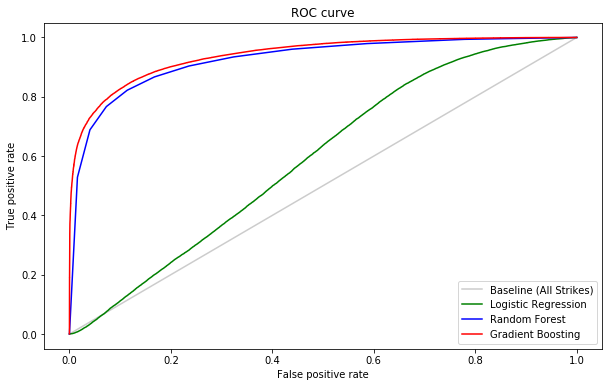

In [236]:
# AUC plots
y_pred_lr = lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

y_pred_rf = randomforest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

y_pred_gbt = gbt.predict_proba(X_test)[:, 1]
fpr_gbt, tpr_gbt, _ = roc_curve(y_test, y_pred_gbt)

y_pred_guess = y_test*0+1
fpr_guess, tpr_guess, _ = roc_curve(y_test, y_pred_guess)

plt.figure(1)
plt.figure(figsize=[10,6])

plt.plot(fpr_guess, tpr_guess, label='Baseline (All Strikes)',c='.8')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression',c='g')
plt.plot(fpr_rf, tpr_rf, label='Random Forest',c='b')
plt.plot(fpr_gbt, tpr_gbt, label='Gradient Boosting',c='r')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [237]:
print ('AUC scores')
y_pred_gbt = gbt.predict_proba(X_test)[:, 1]
fpr_gbt, tpr_gbt, _ = roc_curve(y_test, y_pred_gbt)

print ('Baseline (Guess All Strikes): {}'.format(round(roc_auc_score(y_test, y_pred_guess),3)))
print ('Logistic Regression: {}'.format(round(roc_auc_score(y_test, y_pred_lr),3)))
print ('Random Forest: {}'.format(round(roc_auc_score(y_test, y_pred_rf),3)))
print ('Gradient Boosting: {}'.format(round(roc_auc_score(y_test, y_pred_gbt),3)))

AUC scores
Baseline (Guess All Strikes): 0.5
Logistic Regression: 0.592
Random Forest: 0.924
Gradient Boosting: 0.941


## Running Model on Test Data

In [55]:
dftest = pd.read_csv('2020-test.csv')

In [28]:
dftest.head()

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,tilt,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,is_strike,pitch_id
0,d3396348,Left,d9b3bce2,Right,501b6728,a63083b5,c338c856,8,1,2.0,0,0,93.346497,-1.16644,1.87253,1731.089966,142.365005,10:30,6.26608,-2.61731,5.56952,-23.392500,8.96804,-6.42360,3.16287,-1.488730,85.462196,-5.52951,0.682682,0.411072,2.65519,55,6.30581,FA,NaN,f2204560
1,4c807a49,Left,4aafd18a,Right,8d1f4cfc,93c9014b,97c420bc,1,2,1.0,0,0,82.868401,-1.41442,3.51740,2394.899902,112.483002,9:45,5.85320,-1.94191,7.13341,-30.689501,7.81085,-15.20940,1.90787,-0.035222,76.937698,-7.24994,0.617254,0.446388,2.05217,55,5.89617,CH,NaN,4a16102e
2,18182a03,Right,c790fbeb,Left,075be90a,9c02aab4,568a8108,6,2,1.0,0,0,90.621201,-2.86848,-4.31590,2643.629883,167.151993,11:30,5.89872,1.77701,5.79956,-22.954500,10.97050,-2.84246,1.27567,-2.469280,83.710899,-7.12427,-4.845640,0.421318,-1.78613,55,5.93421,SL,NaN,73ffabd3
3,94a20652,Right,bf921933,Right,934c75c6,043de890,5e710b9e,5,1,1.0,2,2,93.436699,-3.10091,-4.69745,2157.080078,-150.557999,1:00,5.37846,1.48611,6.77311,-14.805000,16.13740,8.26508,1.15670,-2.069660,85.949799,-5.92277,-3.132810,0.400539,-1.56069,55,5.44192,FA,NaN,60ed54c3
4,4f3062b6,Left,65df5b42,Right,c9712626,d057fd71,00ae6fb5,3,1,1.0,3,2,93.542900,-3.18035,4.13387,2220.550049,127.026001,10:15,6.38973,-2.10018,6.27203,-20.771000,10.78990,-14.20540,1.51875,0.573167,85.592598,-7.10051,1.461540,0.406034,2.15070,55,6.43411,FA,NaN,5d720732


In [29]:
dftest.describe()

,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,is_strike
count,145552.000000,145552.000000,145509.000000,145552.000000,145552.000000,145534.000000,145534.000000,145534.000000,143332.000000,145534.000000,145534.000000,145534.000000,145534.000000,145534.000000,145534.000000,145534.000000,145543.000000,145543.000000,145534.000000,145534.000000,145534.000000,145534.000000,145534.000000,145552.0,145534.000000,0.0
mean,5.016214,1.490787,0.982654,0.882159,0.889077,88.753324,-1.505871,-1.026002,2220.085044,153.957069,5.918483,0.768336,6.095914,-26.706713,9.107403,1.990218,2.252625,-0.037514,81.276078,-6.508435,-0.645325,0.429691,-0.774195,55.0,5.942318,NaN
std,2.678508,0.499917,0.817636,0.965563,0.825843,5.902167,1.452841,2.749783,311.776101,104.028058,0.519604,1.981805,0.493239,13.462584,8.852730,10.469311,0.949314,0.867607,5.271911,1.896083,2.235138,0.032159,2.006093,0.0,0.524774,NaN
min,0.000000,1.000000,0.000000,0.000000,0.000000,45.630901,-7.450190,-9.203240,463.131989,-179.998993,1.094650,-5.752130,2.641780,-111.995003,-52.368698,-30.507200,-4.519000,-7.147650,37.297001,-17.108900,-12.197000,0.357956,-5.025050,55.0,1.126210,NaN
25%,3.000000,1.000000,0.000000,0.000000,0.000000,84.606796,-2.494867,-3.051323,2073.065063,120.979248,5.665310,-1.188868,5.776897,-34.461426,4.033368,-6.499740,1.644560,-0.633922,77.772003,-7.688505,-2.211240,0.405522,-2.222075,55.0,5.687643,NaN
50%,5.000000,1.000000,1.000000,1.000000,1.000000,90.019203,-1.649310,-1.902080,2237.729980,181.079498,5.957970,1.554280,6.101745,-23.171050,11.019900,3.157645,2.258890,-0.040828,82.401703,-6.258535,-0.779636,0.421241,-1.570125,55.0,5.983425,NaN
75%,7.000000,2.000000,2.000000,2.000000,2.000000,93.301300,-0.682856,1.253272,2399.722473,219.761993,6.241340,2.201235,6.420653,-15.924150,16.126699,11.063000,2.867685,0.554168,85.242476,-5.142325,0.775463,0.449210,1.207540,55.0,6.266875,NaN
max,18.000000,2.000000,3.000000,4.000000,2.000000,104.460999,13.540500,8.783410,3662.719971,359.967987,8.735570,4.934490,10.461400,158.755005,205.253998,38.336800,14.180100,5.448910,95.513603,25.170700,9.151290,0.905380,5.624980,55.0,8.732170,NaN


In [30]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145552 entries, 0 to 145551
Data columns (total 36 columns):
pitcher_id             145552 non-null object
pitcher_side           145552 non-null object
batter_id              145552 non-null object
batter_side            145552 non-null object
stadium_id             145552 non-null object
umpire_id              145552 non-null object
catcher_id             145552 non-null object
inning                 145552 non-null int64
top_bottom             145552 non-null int64
outs                   145509 non-null float64
balls                  145552 non-null int64
strikes                145552 non-null int64
release_speed          145534 non-null float64
vert_release_angle     145534 non-null float64
horz_release_angle     145534 non-null float64
spin_rate              143332 non-null float64
spin_axis              145534 non-null float64
tilt                   145246 non-null object
rel_height             145534 non-null float64
rel_side    

In [56]:
#Clean input test dataset
dftest.drop(columns=['is_strike'], inplace=True)
dfcut = dftest.drop(columns=['pitcher_id','pitcher_side','batter_id','batter_side','stadium_id', 'umpire_id', \
                             'catcher_id', 'top_bottom','tilt', 'pitch_type', 'y55', 'pitch_id'])
dfnum = dfcut.loc[:,'outs':'z55']
dfin = dfcut.loc[:,'inning']
dfm = pd.concat([dfnum, dfin], axis=1, sort=False)
dfm.fillna(dfm.mean(),inplace=True)

Xt = scaler.transform(dfm)

In [24]:
Xt.shape

(145552, 23)

In [57]:
Xt


array([[ 1.24495664, -0.91555493, -1.07772627, ...,  1.6974236 ,
         0.68838827,  1.11329368],
       [ 0.02142544, -0.91555493, -1.07772627, ...,  1.39779484,
        -0.09092118, -1.49821945],
       [ 0.02142544, -0.91555493, -1.07772627, ..., -0.50938094,
        -0.0185535 ,  0.36714707],
       ...,
       [-1.20210575,  1.15128112,  0.13440059, ..., -0.51269021,
        -0.34571348, -1.12514614],
       [ 0.02142544,  0.11786309,  0.13440059, ..., -0.5623981 ,
        -0.26752372, -1.49821945],
       [ 1.24495664,  1.15128112,  1.34652745, ..., -0.58581109,
        -0.53095297, -0.37899954]])

In [58]:
pred = gbt.predict(Xt)
table = list(zip(dftest['pitch_id'], pred))
dftable = pd.DataFrame(table, columns=['pitch_id','is_strike'])

In [59]:
dftable.sort_values(by='pitch_id')

,pitch_id,is_strike
139758,00003e66,1
30805,000093b1,1
124482,0001a007,0
85496,00034f5a,0
139437,0003cf7c,1
45562,000582d4,1
32606,0005fef1,1
8597,00075475,0
85074,000804a4,1
115115,00082fe0,0


In [60]:
92544+53008

145552

In [61]:
#test
collections.Counter(dftable['is_strike']).most_common()

[(1, 92268), (0, 53284)]

In [63]:
#test
53284/(53284+92268)

0.36608222490931075

In [38]:
temp = pd.DataFrame(scaler.inverse_transform(Xt))

In [29]:
#train data set
collections.Counter(df['is_strike']).most_common()

[(1, 364884), (0, 207752)]

In [30]:
#train data set
207752/(207752+364884)

0.36279940485753603

In [46]:
dftable.to_csv('is_strike.csv')

In [40]:
temp.to_csv('temp.csv')